In [5]:
# Swan = False
# if Swan == True:
%run Utils.py

Running Utilis


In [6]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter 

from scipy.optimize import curve_fit
import copy
import os
import h5py
import json

import PyPDF2                       # Per unire i PDF alla fine
import glob                         # Per manipolazione dei path

from collections.abc import Iterable
from Allineamento import *


In [7]:
Swan = False
if Swan:
    data_dir = "/eos/project/i/insulab-como/testBeam/TB_T9_2023_08_OREO/HDF5"
else:
    data_dir = "./data_22"

config_file = r"./config.json"

with open(config_file, "r") as f:
            dizi = json.load(f)
nRun = dizi["RunAllignment"]

data_path = f'{data_dir}/run{nRun}.h5'


with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    print(hf.keys())
    hf["xpos"].shape
    keys = list(hf.keys())
    for k in hf.keys():
        comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
        exec(comand)

<KeysViewHDF5 ['Ievent', 'digi_base', 'digi_ph', 'digi_time', 'info_plus', 'nclu', 'nstrip', 'xinfo', 'xpos']>


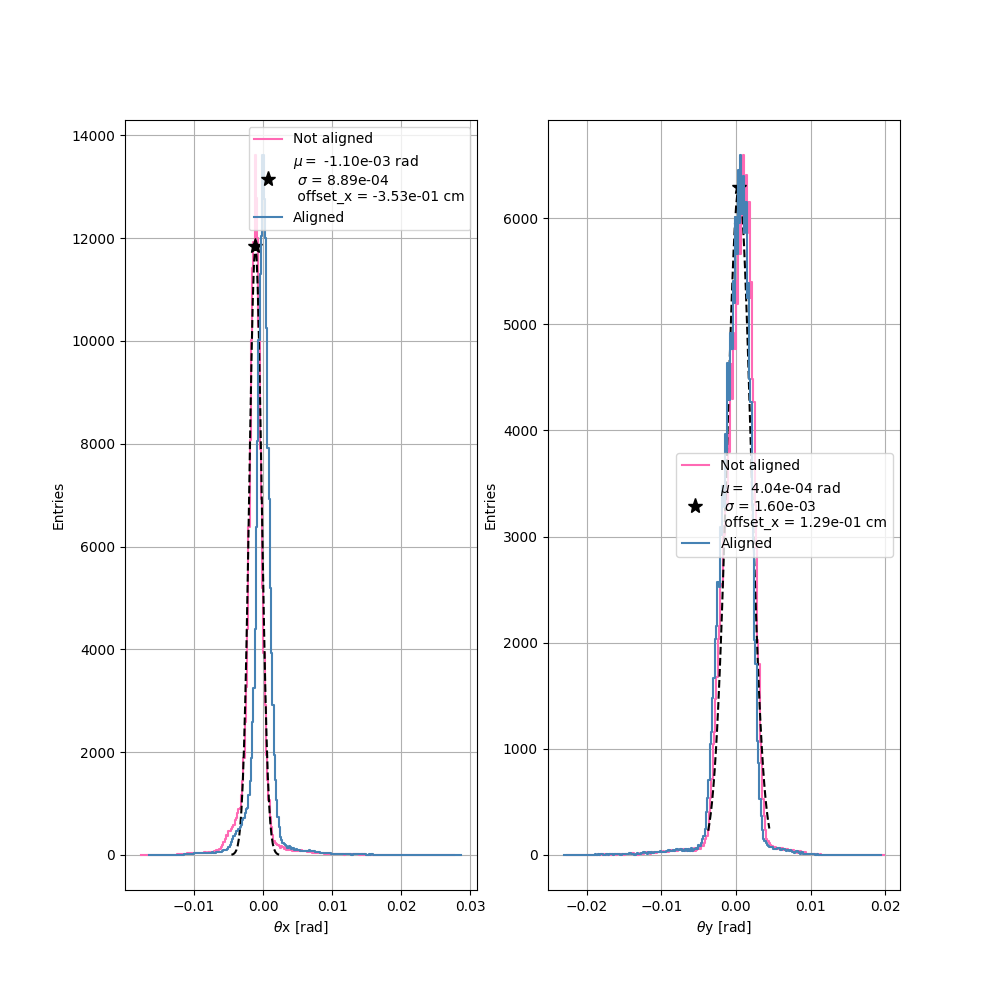

offset_y2  0.12919836895267223
offset_x2  -0.35276844772093113


In [8]:
logic = (xpos > -1) & (xpos < 15)
logic2 = logic.all(axis = 1)

xpos = xpos[logic2]

##x1, y1, x2, y2, d, plotter
offset12, div12 = align(xpos[:,1],xpos[:,0], xpos[:,3],xpos[:,2], dizi["d_12"], True)

dizi = {
    "RunAllignment": nRun,
    "d_12": 320, #cm
    "d_1c": 320+61, #cm
    "offset_x2": offset12[0],
    "offset_y2": offset12[1],
    "div_12x": div12[0],
    "div_12y": div12[1], 
}
d_tele12 = dizi['d_12']
print('offset_y2 ', dizi['offset_y2'])
print('offset_x2 ',dizi['offset_x2'])

xpos[:,2] -= dizi['offset_y2']
xpos[:,3] -= dizi['offset_x2']


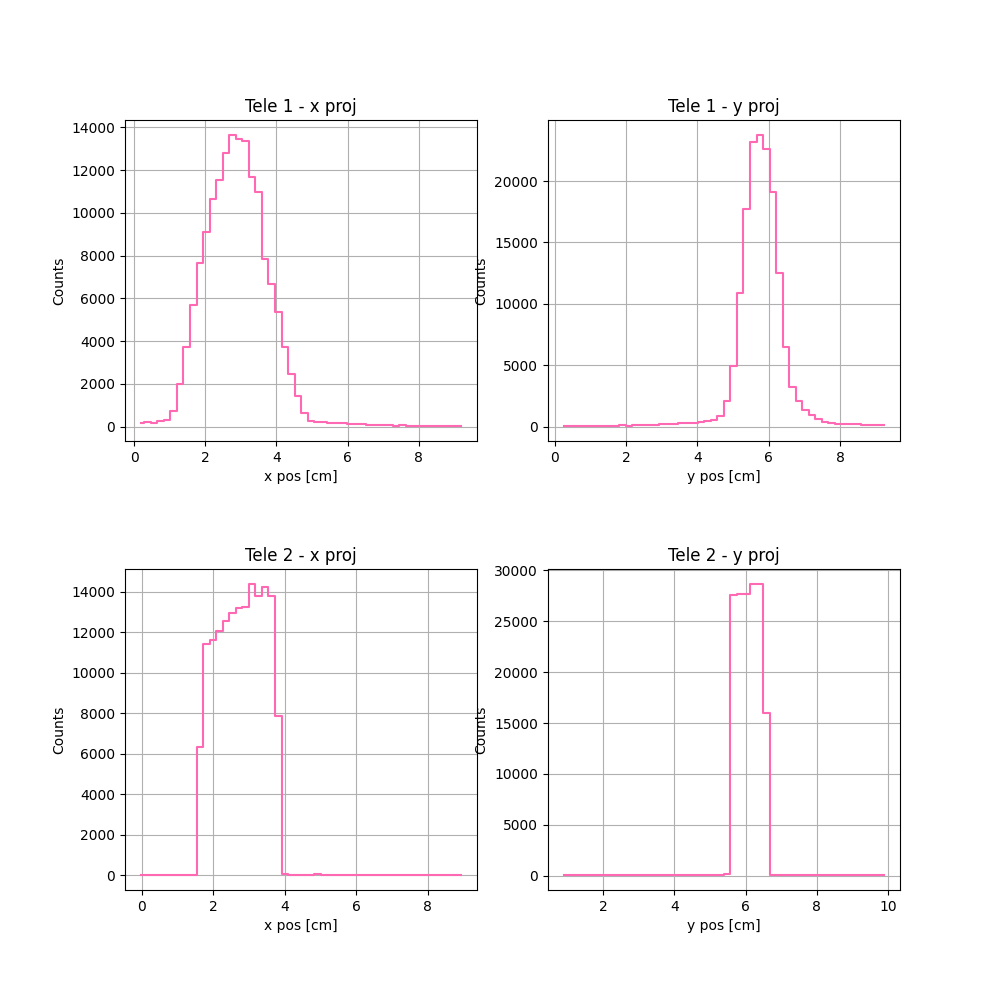

In [9]:
fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4)
fig.set_size_inches(10,10)

for i in range(2):
    ax = axes[i,0]
    ax.set_title(f"Tele {i+1} - x proj")
    
#   h, c = np.histogram(xpos[:,2*i], bins = 384)
    h, c = np.histogram(xpos[:,2*i], bins = 50)
    c = c[:-1] + (c[1]+c[0])/2
    
    ax.plot(c, h, ds = 'steps-mid', c = 'hotpink')
    
    ax.set_xlabel("x pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()
    
    ax = axes[i,1]
    ax.set_title(f"Tele {i+1} - y proj")
    
#    h, c = np.histogram(xpos[:,2*i+1], bins = 384)
    h, c = np.histogram(xpos[:,2*i+1], bins = 50)
    c = c[:-1] + (c[1]+c[0])/2
    
    ax.plot(c, h, ds = 'steps-mid', c = 'hotpink')    
    
    ax.set_xlabel("y pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()

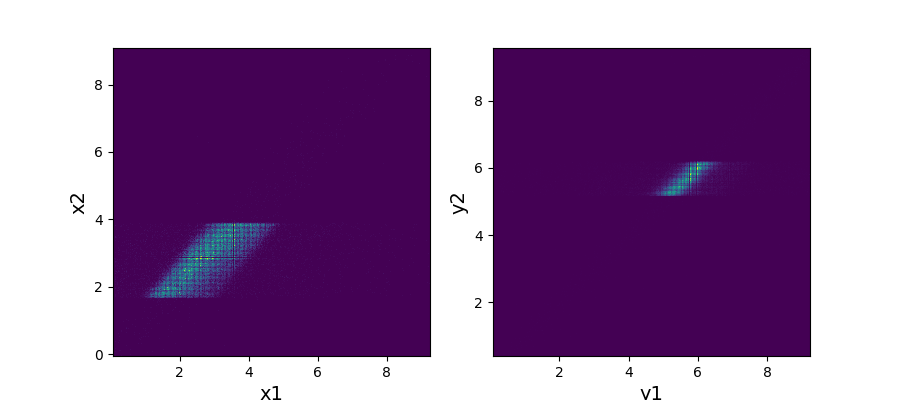

In [10]:
lstCoord = ["x1","y1","x2","y2"]

fig, ax = plt.subplots(1,int(len(xpos[1,:]))-2)
fig.set_size_inches(9,4)
# fig.subplots_adjust(hspace = 0.9)

for i in range(int(len(xpos[1,:]))-2):
    # print(f'{i+1}-{(len(xpos[1,:]))}')
    if i <= 3:
        ax[i].hist2d(xpos[:,i],xpos[:,i+2],bins=500)
        ax[i].set_xlabel(lstCoord[i],fontsize = 14)
        ax[i].set_ylabel(lstCoord[i+2], fontsize = 14)   
plt.show()

La divergenza in x vale 898.08 urad
La divergenza in y vale 1611.41 urad


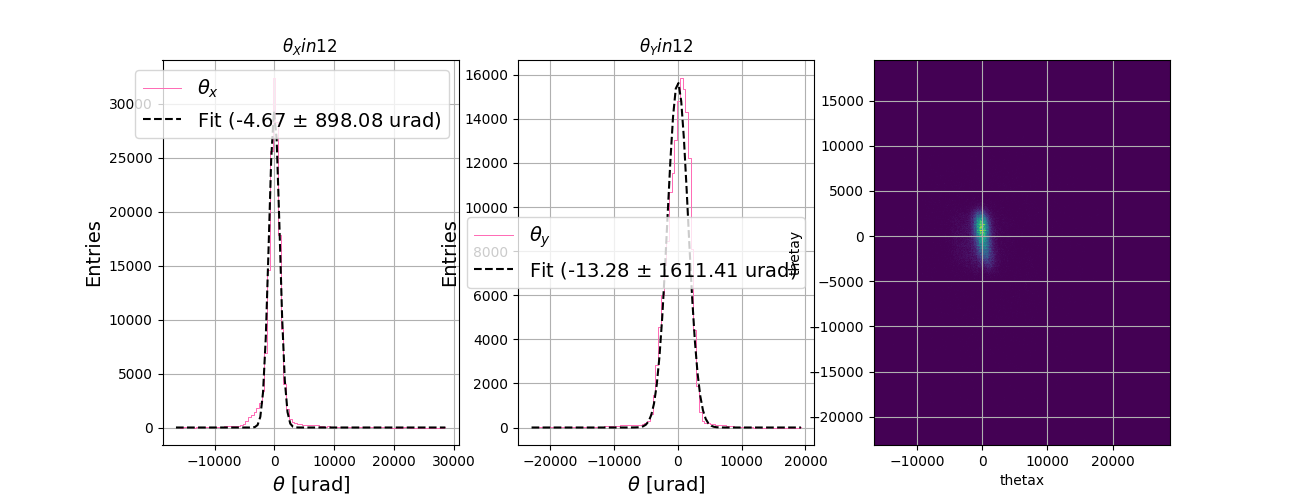

In [11]:
deltaX = xpos[:,3]-xpos[:,1]# tele 2-1
deltaY = xpos[:,2]-xpos[:,0]# tele 2-1

theta_12_x = np.arctan(deltaX/d_tele12) * 1e6 # urad
theta_12_y = np.arctan(deltaY/d_tele12) * 1e6 # urad

theta12 = [theta_12_x, theta_12_y]
thetaLbl = ["x", "y"]
num_bins = 500

fig, ax = plt.subplots(1,3)
fig.set_size_inches(13,5)

titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in12 $"]
popt_list12 =[]
for i in range(2):
    h, bins = np.histogram(theta12[i], bins = 100, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2

    p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    popt_list12.append(popt[1])
    ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} urad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 14)    
    ax[i].set_xlabel(r"$\theta$ [urad]",fontsize = 14)
    
    ax[i].legend(fontsize = 14)
    
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")


# Creazione del plot
ax[2].hist2d(theta12[0], theta12[1], bins=num_bins)

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel('thetax')
ax[2].set_ylabel('thetay')
        

plt.show()

In [12]:
# deltaX = xpos[:,4]-xpos[:,0] # tele 3-1
# deltaY = xpos[:,5]-xpos[:,1] # tele 3-1

# theta_13_x = np.arctan(deltaX/d_tele13) * 1e3 # mrad
# theta_13_y = np.arctan(deltaY/d_tele13) * 1e3 # mrad

# theta13 = [theta_13_x, theta_13_y]
# thetaLbl = ["x", "y"]
# num_bins = 500

# fig, ax = plt.subplots(1,3)
# fig.set_size_inches(13,5)

# titles = [fr"$\theta_X in 13$ ", fr"$\theta_Y in13 $"]
# popt_list13 =[]
# for i in range(2):
#     h, bins = np.histogram(theta13[i], bins = 100, )
#     binc = bins[:-1] + (bins[1] - bins[0]) / 2

#     p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
#     cond = h>0
#     popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
#     popt_list13.append(popt[1])
#     ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
#                label = fr"$\theta_{thetaLbl[i]}$")
    
#     ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} mrad)")
    
#     ax[i].grid()
#     ax[i].set_title(titles[i])
#     ax[i].set_ylabel("Entries", fontsize = 14)    
#     ax[i].set_xlabel(r"$\theta$ [mrad]",fontsize = 14)
    
#     ax[i].legend(fontsize = 14)
    
#     print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} mrad")


# # Creazione del plot
# ax[2].hist2d(theta13[0], theta13[1], bins=num_bins)

# # Etichette degli assi
# ax[2].grid()
# ax[2].set_xlabel('thetax')
# ax[2].set_ylabel('thetay')
        

# plt.show()

In [13]:
# ## CALCOLO OFFSET X Y PER CENTRARE I THETA
# offsetx2 = np.tan(popt_list12[0] * 1e-3) * d_tele12
# offsety2 = np.tan(popt_list12[1] * 1e-3) * d_tele12

# offsetx3 = np.tan(popt_list13[0] * 1e-3) * d_tele13
# offsety3 = np.tan(popt_list13[1] * 1e-3) * d_tele13

# print(popt_list12,popt_list13)
# print()

# ##### COPY AND PASTE THIS OUTPUT IN THE ANALYSIS CODE #####
# print(f'offsetx2 = {offsetx2} # cm')
# print(f'offsety2 = {offsety2} # cm')
# print(f'offsetx3 = {offsetx3} # cm')
# print(f'offsety3 = {offsety3} # cm')
# ###########################################################

# print()
# print(f'Off2 {10000*offsetx2:.4f} um ,{10000*offsety2:.4f} um')
# print(f'Off3 {10000*offsetx3:.4f} um ,{10000*offsety3:.4f} um')


In [14]:
x1 = xpos[:,0]
y1 = xpos[:,1]
x2 = xpos[:,2]
y2 = xpos[:,3]

rot = xinfo[:,0]

(3,)
La divergenza in x vale 1611.41 urad
La divergenza in y vale 898.08 urad


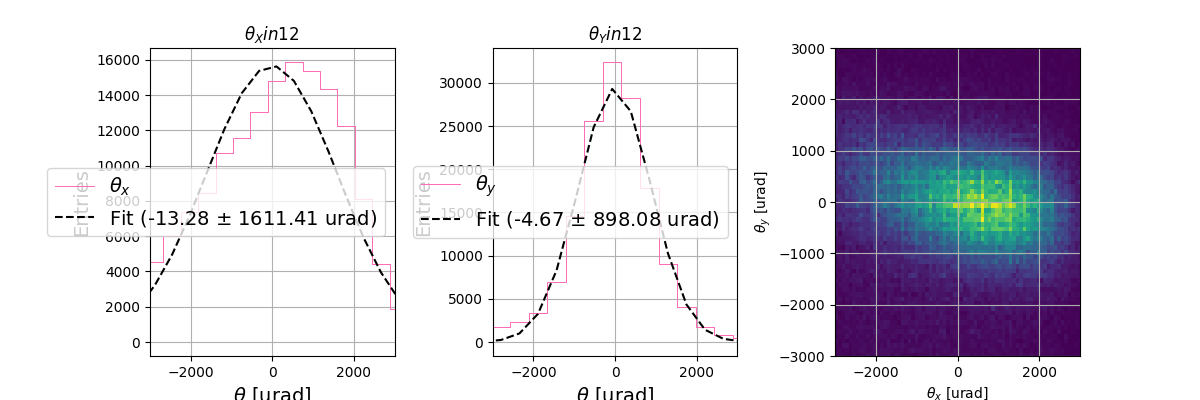

In [15]:
theta_12_x = np.arctan((x2-x1)/d_tele12) * 1e6 # urad
theta_12_y = np.arctan((y2-y1)/d_tele12) * 1e6 # urad

theta12 = [theta_12_x, theta_12_y]

thetaLbl = ["x","y","_"]
num_bins = 500

fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax=ax.flatten()
print(ax.shape)
titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in 12 $","_"]
for i in range(3):
    if i<2:
        h, bins = np.histogram(theta12[i], bins = 100)
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
    if i== 2:
        continue
    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    # ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} mrad)")
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} urad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 14)    
    ax[i].set_xlabel(r"$\theta$ [urad]",fontsize = 14)
    
    ax[i].legend(fontsize = 14)
    
    # print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} mrad")
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")


# Creazione del plot
ax[2].hist2d(theta12[0], theta12[1], bins=num_bins)

for a in ax: 
    # a.set_xlim((-0.5,+0.5)) #mrad
    a.set_xlim((-3000,+3000))

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel(r'$\theta_x$ [urad]')
ax[2].set_ylabel(r'$\theta_y$ [urad]')
ax[2].set_ylim((-3000,+3000))

        

plt.show()

In [16]:
with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)